In [123]:
import pandas as pd
import geopandas as gpd
import json

import xml.etree.ElementTree as ET
from shapely.geometry import MultiPolygon, Polygon, shape
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from unidecode import unidecode 

In [124]:
data_path = 'raw/'
output_path = 'output/'

In [9]:
# ##This is to export the linestrings. It's probably unnecessary
# gml_file_path = data_path+'AdministrativeUnitsAndBoundaries.gml'
# tree = ET.parse(gml_file_path)
# root = tree.getroot()

# # Define namespaces
# namespaces = {
#     'au': 'http://inspire.ec.europa.eu/schemas/au/4.0',
#     'gml': 'http://www.opengis.net/gml/3.2',
#     'wfs': 'http://www.opengis.net/wfs/2.0',
# }

# # Create lists to store LineString geometries and their corresponding IDs
# geometries = []
# ids = []

# # Iterate through each <wfs:member> element
# for member in root.findall(".//wfs:member", namespaces=namespaces):
#     # Find the <au:AdministrativeBoundary> element within <wfs:member>
#     admin_boundary = member.find(".//au:AdministrativeBoundary", namespaces=namespaces)
#     if admin_boundary is not None:
#         # Extract the gml:id attribute
#         admin_id = admin_boundary.get("{http://www.opengis.net/gml/3.2}id")
        
#         # Extract the <gml:LineString> element
#         line_string_elem = admin_boundary.find(".//gml:LineString", namespaces=namespaces)
#         if line_string_elem is not None:
#             # Extract the <gml:posList> element
#             pos_list_elem = line_string_elem.find(".//gml:posList", namespaces=namespaces)
#             if pos_list_elem is not None:
#                 # Extract and parse the coordinates from the <gml:posList> element
#                 coordinates = [float(pos) for pos in pos_list_elem.text.split()]
#                 # Create a LineString geometry with 2D coordinates
#                 line_string = LineString([(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)])
#                 geometries.append(line_string)
#                 ids.append(admin_id)

# # Create a GeoPandas GeoDataFrame with geometry and id columns
# gdf_adminlines = gpd.GeoDataFrame({'geometry': geometries, 'id': ids}, crs="EPSG:3045")
# gdf_adminlines.to_file(output_path+"admin_lines.shp")## this is probably unnecessary

In [125]:
# Load the GML file
gml_file_path = data_path+'AdministrativeUnitsAndBoundaries.gml'
tree = ET.parse(gml_file_path)
root = tree.getroot()

# Define namespaces
namespaces = {
    'au': 'http://inspire.ec.europa.eu/schemas/au/4.0',
    'gml': 'http://www.opengis.net/gml/3.2',
    'gn': 'http://inspire.ec.europa.eu/schemas/gn/4.0',
}

# Create lists to store MultiPolygon geometries, IDs, and locality names
geometries = []
ids = []
locality_names = []

# Iterate through all <au:AdministrativeUnit> elements
for admin_unit in root.findall(".//au:AdministrativeUnit", namespaces=namespaces):
    # Extract the gml:id attribute
    admin_id = admin_unit.get("{http://www.opengis.net/gml/3.2}id")
    
    # Check if the gml:id attribute starts with "NC"
    if admin_id and admin_id.startswith("NC"):
        # Extract the locality name from <gn:text> element
        locality_elem = admin_unit.find(".//gn:SpellingOfName/gn:text", namespaces=namespaces)
        locality_name = locality_elem.text if locality_elem is not None else None
        
        # Extract the <gml:MultiSurface> element
        multi_surface_elem = admin_unit.find(".//gml:MultiSurface", namespaces=namespaces)
        if multi_surface_elem is not None:
            # Extract and parse the coordinates for all polygons in the MultiSurface
            polygons = []
            for polygon_elem in multi_surface_elem.findall(".//gml:Polygon", namespaces=namespaces):
                pos_list_elem = polygon_elem.find(".//gml:posList", namespaces=namespaces)
                if pos_list_elem is not None:
                    coordinates = [float(coord) for coord in pos_list_elem.text.split()]
                    # Group the coordinates into pairs (x, y)
                    coords_pairs = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
                    reversed_coords_pairs = [(y, x) for x, y in coords_pairs]
                    # Create a Polygon geometry from the coordinates
                    polygon = Polygon(reversed_coords_pairs)
                    polygons.append(polygon)
            
            # Create a MultiPolygon geometry from the extracted polygons
            if polygons:
                
                multi_polygon = MultiPolygon(polygons)
                geometries.append(multi_polygon)
                ids.append(admin_id)
                locality_names.append(locality_name)

# Create a GeoPandas GeoDataFrame with geometry, id, and locality_name columns
original_gdf = gpd.GeoDataFrame({'geometry': geometries, 'id': ids, 'locality_name': locality_names}, crs="EPSG:3045")

Now that we've got the geometries, we could manipulate the localities.json

In [148]:
with open('raw/localities.json', 'r') as json_file:
    data = json.load(json_file)

for entry in data.get("localities",[]):
    entry['plain_name'] = unidecode(entry["English name"])

# Save the modified JSON data (replace 'output_data.json' with your desired output file path)
try:
    with open('raw/localities_mod.json', 'w', encoding='utf-8') as output_file:
        json.dump(data, output_file, indent=4, ensure_ascii=False)
    print("Conversion completed and saved.")
except Exception as e:
    print("Error saving JSON data:", str(e))

Conversion completed and saved.


In [232]:
import pandas as pd
import json
from fuzzywuzzy import fuzz, process
# Load the OPEN DATA JSON data
with open('raw/localities_mod.json', 'r') as json_file:
    json_data = json.load(json_file)   


json_df = pd.DataFrame(json_data['localities'])# Create a DataFrame from the JSON data
gdf = original_gdf  

print("Lengths of each dataframe", len(gdf), len(json_df))
# Create an empty list to store matched locality names
matched_locality_names = []
# Create a list to store aliases
aliases_list = []

# Iterate through the JSON locality names
for index, row in json_df.iterrows():
    english_name = row['English name']
    maltese_name = row['Maltese name']
    plain_name = row["plain_name"]

     # Check for parentheses in Maltese name
    if '(' in maltese_name and ')' in maltese_name:
        aliases = maltese_name[maltese_name.find('(') + 1:maltese_name.find(')')]
        aliases_list.append(aliases)
        maltese_name = maltese_name.replace(f' ({aliases})', '')  # Remove content within parentheses
        json_df.at[index, 'Maltese name'] = maltese_name
    else:
        aliases_list.append(None)
    
    # Try to match on English name first
    match = process.extractOne(plain_name, gdf['locality_name'], scorer=fuzz.partial_ratio)
    # If no match on English name, try Maltese name
    if match is None or match[1] < 90:
        match = process.extractOne(maltese_name, gdf['locality_name'], scorer=fuzz.partial_ratio)
    #If no match on Maltese name, try plain name
    if match is None or match[1] < 90:
        match = process.extractOne(english_name, gdf['locality_name'], scorer=fuzz.partial_ratio)
    # Append the matched locality name or None if no match is found
    matched_locality_names.append(match[0] if match and match[1] >= 80 else None) #60% match

# Add the matched locality names as a new column in the JSON DataFrame
json_df['matched_locality_name'] = matched_locality_names
# Add the aliases as a new column in the JSON DataFrame
json_df['aliases'] = aliases_list

# Merge the two DataFrames based on the matched locality names
merged_df = pd.merge(json_df, gdf, left_on='matched_locality_name', right_on='locality_name', how='inner')

# Check if there are non-matching localities
non_matching_localities = json_df[~json_df['English name'].isin(merged_df['English name'])]

# Print a message if there are non-matching localities
if not non_matching_localities.empty:
    print("WARNING! Non-matching localities found:")
    print(non_matching_localities['English name'].tolist())
    print("Manual intervention may be required.")
else:
    print("All localities matched successfully.")


# Check for duplicate locality_admin_id values
duplicates = merged_df[merged_df.duplicated(subset='id', keep=False)]

# Print the rows with duplicate locality_admin_id values
if not duplicates.empty:
    print("\nDuplicate locality_admin_id values found:")
    print(duplicates['English name'].tolist())
    print("This means that geoms would have been duplicated too. Manual intervention may be required.")
else:
    print("No duplicate locality_admin_id values found.")


# Select the desired columns
merged_df = merged_df[['ID', 'id', 'locality_name', 'English name', 'Maltese name','plain_name','aliases', 'Island', 'Region', 'Statistical District', 'geometry']]

# Rename columns in the merged DataFrame
merged_df = merged_df.rename(columns={
    'ID': 'locality_id',
    'id': 'locality_admin_id',
    'English name': 'english_name',
    'Maltese name': 'maltese_name',
    'Statistical District': 'statistical_district',
    'Island': 'island',
    'Region': 'region'
})


Lengths of each dataframe 68 67
WARNING! Non-matching localities found:
['Żebbuġ (Gozo)']
Manual intervention may be required.

Duplicate locality_admin_id values found:
['Marsa', 'Marsaxlokk']
This means that geoms would have been duplicated too. Manual intervention may be required.


manual intervention

In [281]:
# MANUAL INTERVENTION
row_index = merged_df[merged_df['locality_id'] == 25].index[0]  # Get the index of the row with ID 25
merged_df.loc[row_index, 'locality_name'] = 'MARSA'# Update the locality_name for the row with ID 25

row_index = merged_df[merged_df['locality_id'] == 26].index[0] 
merged_df.loc[row_index, 'locality_name'] = 'MARSASCALA'

row_index = merged_df[merged_df['locality_id'] == 44].index[0] 
merged_df.loc[row_index, 'island'] = 'Gozo'
merged_df.loc[row_index, 'region'] = 'Gozo'
merged_df.loc[row_index, 'statistical_district'] = 'Gozo & Comino'	

In [290]:
# Assuming you have two DataFrames: original_gdf and merged_df

# Create an empty list to store the matches
matches = []

# Iterate through each row in original_gdf
for _, row in original_gdf.iterrows():
    english_name = row['locality_name']
    # Use fuzzywuzzy's process function to find the best match in merged_df
    match_and_score = process.extractOne(english_name, merged_df['locality_name'])
    # The result is a tuple with match and score as its first element
    match = match_and_score[0]
    score = match_and_score[1]
    # You can choose a threshold score to consider as a valid match
    if score >= 90:  # Adjust the threshold as needed
        matches.append((english_name, match, score))

# Create a DataFrame from the matches list
matches_df = pd.DataFrame(matches, columns=['original_name', 'locality_name', 'score'])
matches_df = pd.merge(matches_df,original_gdf, on='locality_name')

In [292]:
merged_df2 = pd.merge(merged_df, matches_df,on='locality_name', how='inner')
merged_df2 = merged_df2.drop(['geometry_x','locality_admin_id'], axis=1)
merged_df2 = merged_df2.rename(columns={'geometry_y': 'geometry','id':'admin_id'})

In [305]:
selected_locality_id = 'ZEBBUG (Ghawdex)'  # Replace with the specific 'locality_id' you want to select

# Find the row with the specific 'locality_id' in the 'source_df'
selected_row = original_gdf[original_gdf['locality_name'] == selected_locality_id]

# Check if the row with the specified 'locality_id' was found
if not selected_row.empty:
    # Add the selected row to the 'target_df'
    target_df = pd.concat([merged_df2, selected_row], ignore_index=True)
else:
    print(f"Row with 'locality_id' {selected_locality_id} not found in 'source_df'")
    
selected_locality_id2 = 'RABAT (Malta)'  # Replace with the specific 'locality_id' you want to select
# Find the row with the specific 'locality_id' in the 'source_df'
selected_row2 = original_gdf[original_gdf['locality_name'] == selected_locality_id2]

# Check if the row with the specified 'locality_id' was found
if not selected_row.empty:
    # Add the selected row to the 'target_df'
    target_df = pd.concat([target_df, selected_row2], ignore_index=True)
else:
    print(f"Row with 'locality_id' {selected_locality_id} not found in 'source_df'")

In [308]:
#### SAVE to CSV
target_df.to_csv(output_path+"localities.csv", index=None)
### CONVERT TO GEODATAFRAME AND EXPORT TO SHP
gdf = gpd.GeoDataFrame(target_df, geometry='geometry')
gdf.to_file(output_path+"localities.shp") 

C:\Users\Owner\AppData\Local\Temp\ipykernel_22032\3374589504.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path+"localities.shp")


## plot

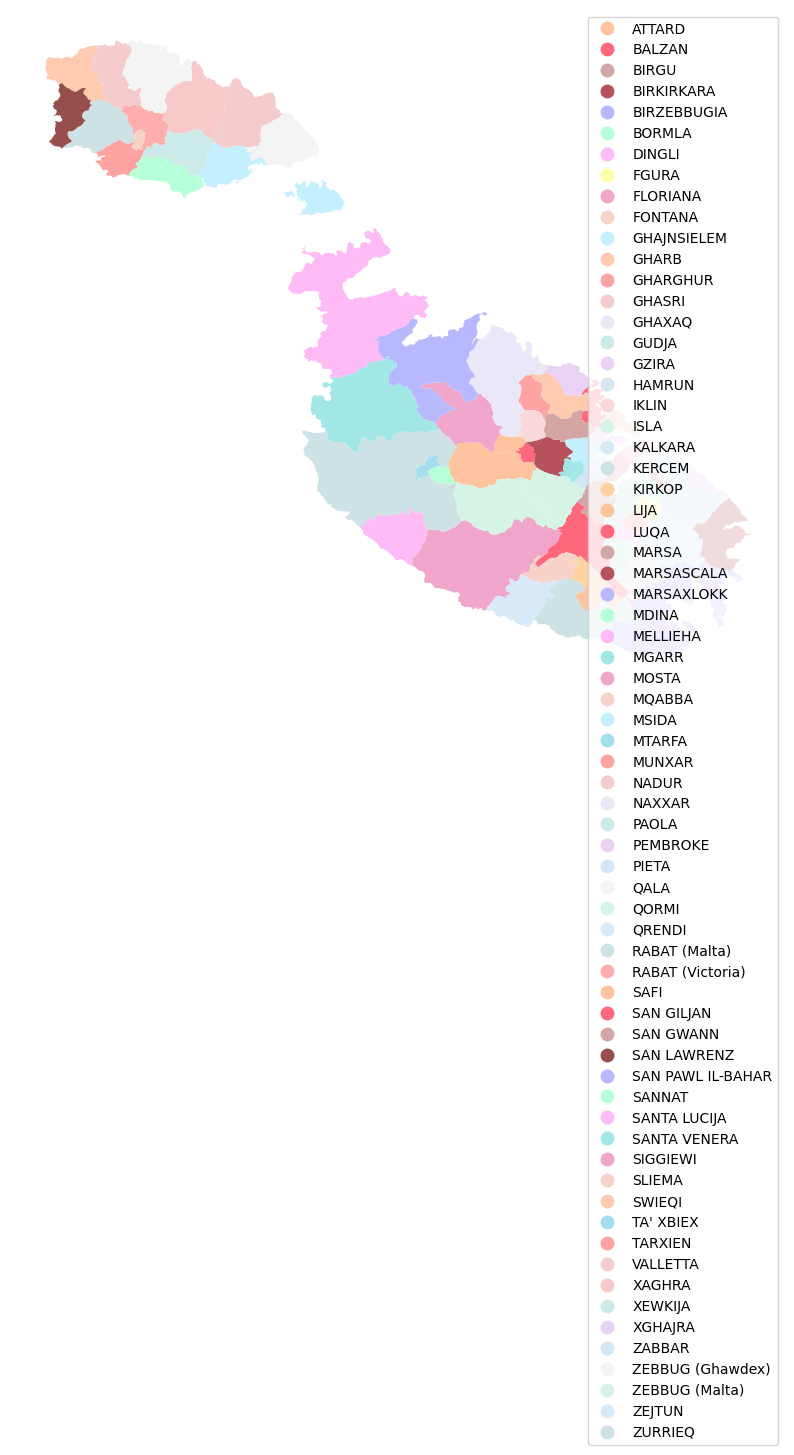

In [309]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a list of 68 pastel-like distinct colors
distinct_colors = [
    "#FFC3A0", "#FF677D", "#D4A5A5", "#B5525C", "#964F4C", "#B8B8FF",
    "#B5FFD9", "#FFBBF5", "#FFFEA6", "#A0E7E5", "#F0A6CA", "#F7D2C8",
    "#C3EFFF", "#FFCAAF", "#A4DDED", "#FFA2A2", "#F4CCCC", "#EAE7F8",
    "#F8C9C9", "#CCEAE7", "#EAD2F4", "#D2E6F4", "#F8D8D8", "#F4F4F4",
    "#D5F4E6", "#D8EAF8", "#CCE2E4", "#FFD2A2", "#FFADAD", "#FFC3A0",
    "#FF677D", "#D4A5A5", "#B5525C", "#964F4C", "#B8B8FF", "#B5FFD9",
    "#FFBBF5", "#FFFEA6", "#A0E7E5", "#F0A6CA", "#F7D2C8", "#C3EFFF",
    "#FFCAAF", "#A4DDED", "#FFA2A2", "#F4CCCC", "#EAE7F8", "#F8C9C9",
    "#CCEAE7", "#EAD2F4", "#D2E6F4", "#F8D8D8", "#F4F4F4", "#D5F4E6",
    "#D8EAF8", "#CCE2E4", "#FFD2A2", "#FFADAD", "#FFC3A0", "#FF677D",
    "#D4A5A5", "#B5525C", "#964F4C", "#B8B8FF", "#B5FFD9", "#FFBBF5",
    "#FFFEA6", "#A0E7E5", "#F0A6CA", "#F7D2C8", "#C3EFFF", "#FFCAAF",
    "#A4DDED", "#FFA2A2", "#F4CCCC", "#EAE7F8", "#F8C9C9", "#CCEAE7",
    "#EAD2F4", "#D2E6F4", "#F8D8D8", "#F4F4F4", "#D5F4E6", "#D8EAF8",
    "#CCE2E4"
]

# Create a custom colormap with the list of pastel-like distinct colors
custom_cmap = ListedColormap(distinct_colors)

# Plot the GeoDataFrame with the custom colormap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column="locality_name", cmap=custom_cmap, legend=True, legend_kwds={'bbox_to_anchor': (1, 1)})
ax.axis("off")
plt.show()